# H-MHSA

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [2]:
class CNN(nn.Module):
    def __init__(self, kernel_size, stride, padding): # kernel = 3, stride = 2, padding = 1
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = kernel_size, stride = stride, padding = padding)
        #bias=True - put false??
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 64, kernel_size = kernel_size, stride = stride, padding = padding)
        self.bn2 = nn.BatchNorm2d(64)
        self.silu = nn.SiLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.silu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.silu(x)
        #x = torch.flatten(x, 1)
        
        return x

cnn = CNN()

In [ ]:
class Downsample(nn.Module): #page 4, paragraph 2
    def __init__(self, in_channels, out_channels, kernel_size): #kernel = 3
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding = 1, stride = 2)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        
        return x

In [8]:
class HMHSA(nn.Module):
    def __init__(self, dim, head, grid_size, ds_ratio, drop): # we have an embedding and we are going to split it in (heads) =! parts
        super(SelfAttention, self).__init__()
        self.dim = dim
        self.head = head
        self.num_heads = dim // head
        self.grid_size = grid_size
        
        assert (self.num_heads * head == dim), "Dim needs to be divisible by Head."
        
        self.qkv = nn.Linear(self.dim, self.dim, bias = False) # q, k, v are all the same   # DUV 
        #self.qkv = nn.Conv2d(dim, dim * 3, 1)
        # DUV - why bias = False?
        self.proj = nn.Conv2d(dim, dim, 1) # DUV
        self.drop = nn.Dropout2d(drop, inplace = True)

        if grid_size > 1:
            self.norm1 = nn.GroupNorm(1, dim)
            self.avg_pool = nn.AvgPool2d(ds_ratio, stride = ds_ratio) # DUV - average pooling with both the kernel size and stride of G2
            self.q = nn.Linear(self.dim, self.dim, bias = False) # DUV
            #self.q = nn.Conv2d(dim, dim, 1)
            self.kv = nn.Linear(self.dim, self.dim, bias = False) # DUV
            #self.kv = nn.Conv2d(dim, dim * 2, 1)
        
    def forward(self, x, mask): # DUV mask
        N, C, H, W = x.shape # N - nº samples, C, H, W - feature dimension, height, width of x (see paper)
        qkv = self.qkv(x) # do linear
        #qkv = self.qkv(self.norm(x))

        if self.grid_size > 1:

            # formula (6)
            grid_h, grid_w = H // self.grid_size, W // self.grid_size # grid_h - H/G_1; grid_w - W/G_1 -> paper(6)
            qkv = qkv.reshape(N, 3, self.num_heads, self.head, grid_h, self.grid_size, grid_w, self.grid_size) # 3 bc qkv; head=C; grid_h*grid_size=H... -> paper(6) --- DUV NUM_HEADS
            qkv = qkv.permute(1, 0, 2, 4, 6, 5, 7, 3) # (3, N, num_heads, grid_h, grid_w, grid_size, grid_size, head) -> paper(6) 2nd eq.
            qkv = qkv.reshape(3, -1, self.grid_size * self.grid_size, self.head) # -1 -> single dim --- DUV WHY --- -> reshape to paper(6) 2nd eq.
            query, key, value = qkv[0], qkv[1], qkv[2]
        
            # eq. (2)
            attention = query @ key.transpose(-2, -1) # DUV TRANSPOSE

            if mask is not None:
                attention = attention.masked_fill(mask = 0, value = float("-1e20"))

            attention = torch.softmax(attention / (self.dim ** (1/2)), dim = -1) # DUV SOFTMAX DIM

            # formula (8)
            attention_x = (attention @ value).reshape(N, self.num_heads, grid_h, grid_w, self.grid_size, self.grid_size, self.head)
            attention_x = attention_x.permute(0, 1, 6, 2, 4, 3, 5).reshape(N, C, H, W) # (N, num_heads, head, grid_h, grid_size, grid_w, grid_size)

            # DUV NOT CONCATENAT AFTER ATTENTION?

            #formula (9)
            attention_x = self.norm1(attention_x + x)
            #grid_x = self.grid_norm(x + grid_x)

            # DUV NOT FEED FORWARD?

            # formula (10)
            kv = self.kv(self.avg_pool(attention_x))
            #kv = self.kv(self.ds_norm(self.avg_pool(grid_x)))

            # formula (11)(12)
            query = self.q(attention_x).reshape(N, self.num_heads, self.head, -1) #DUV -1
            query = query.transpose(-2, -1) # (N, num_heads, -1, head) 
            kv = kv.reshape(N, 2, self.num_heads, self.head, -1) # DUV -1
            kv = kv.permute(1, 0, 2, 4, 3) # (2, N, num_heads, -1, head)
            key, value = kv[0], kv[1]

        else:
            qkv = qkv.reshape(N, 3, self.num_heads, self.head, -1)
            qkv = qkv.permute(1, 0, 2, 4, 3) # (2, N, num_heads, -1, head)
            query, key, value = qkv[0], qkv[1], qkv[2]  

        # eq. (2)
        attention = query @ key.transpose(-2, -1)

        if mask is not None:
                attention = attention.masked_fill(mask = 0, value = float("-1e20"))

        attention = torch.softmax(attention / (self.dim ** (1/2)), dim = -1)

        # formula (13)
        global_attention_x = (attention @ value).transpose(-2, -1).reshape(N, C, H, W)

        # DUV NOT CONCATENAT?
        # DUV NOT NORM AND FEED FORWARD?

        # formula (14)
        if self.grid_size > 1:
            global_attention_x = global_attention_x + attention_x

        x = self.drop(self.proj(global_attention_x)) # DUV DROP, why not add x 
        
        return x

In [ ]:
#we add a depthwise separable convolution (DW-Conv) [30] inside the MLP as widely done.


In [148]:
# VER VIDEO DE NOVO

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads): # change name embed_size,heads - we have an embedding and we are going to split it in (heads) =! parts
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        
        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads."
        
        #1. in __init__:  self.queries = nn.Linear(self.embed_size, self.embed_size, bias=False) (same for key and value weights)
        #2. in forward: put "queries = self.queries(queries)" above "queries = queries.reshape(...)" (also same for keys and values)
        # before - self.head_dim on self.embed_size
        
        self.values = nn.Linear(self.embed_size, self.embed_size, bias = False)
        self.keys = nn.Linear(self.embed_size, self.embed_size, bias = False)
        self.queries = nn.Linear(self.embed_size, self.embed_size, bias = False)
        # DUV - why bias = False?
        self.fc_out = nn.Linear(head * self.head_dim, embed_size) # concatenat
        
    def forward(self, values, keys, queries, mask): # DUV mask
        N = queries.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]
        
        # do linear
        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)
        
        # split embedding into each heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim) 
        keys = keys.reshape(N, keys_len, self.heads, self.head_dim) 
        queries = queries.reshape(N, queries_len, self.heads, self.head_dim) 
        # 1 - nº conj matrix, 2 - nº matrix, 3 - lines, 4 - columns --- DUV
        
        # calculate QK^T
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim)
        # keys shape: (N, key_len, heads, heads_dim)
        # energy shape: (N, heads, query_len, key_len) --- DUV
        
        if mask is not None:
            energy = energy.masked_fill(mask = 0, value = float("-1e20"))
            
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim = 3)
        # DUV - dim=3
        
        out = self.fc_out(out)
        
        return out

In [149]:
# VER VIDEO DE NOVO

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        
        # Position-wise Feed-Forward Network (2)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size)
        )
        
        # applying dropout after the feed forward network and the mha to prevent overfitting
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        
        x = self.dropout(self.norm1(attention + query)) # + -> skip connection
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        
        return out

In [151]:
#ver video

class Encoder(nn.Module):
    def __init__(self, source_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device # DUV - what is device?
        self.word_embedding = nn.Embedding(source_vocab_size, embed_size) # DUV
        self.position_embedding = nn.Embedding(max_length, embed_size) # DUV
        
        self.layers = nn.ModuleList( # DUV - modulelist
            [
                TransformersBlock(embed_size, heads, dropout = dropout, forward_expansion = forward_expansion)
            for _ in range(num_layers)]
        )
        self.dropout = nn.Droupout(droupout)
        
    def forward(self, x, mask):
        N, seq_length = x.shape
        # getting positions
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions)) # input embedding + positional encoding
        
        for layer in self.layers:
            out = layer(out, out, out, mask) # key, value, query are all the same = out
            
        return out

In [152]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, device):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion)
        self.dropout = nn.Droupout(dropout)
        
    def forward(self, x, value, key, source_mask, target_mask): # source mask and target mask difference - 1st is the one for the encoder (opt.), 2nd is for the decoder
        attention = self.attention(x, x, x, target_mask) # all the 3 inputs - k, q, v are the same
        query = self.droupout(self.norm(attention + x)) # skip connection; what we obtain from this block is the query for the next
        out = self.transformer_block(value, key, query, source_mask)
        
        return out

In [153]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_si, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length):
        super(Decoder, self).__init__()
        self.device = device
        self.word_embedding = nn.Embedding(target_vocab_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)
        
        self.layers = nn.ModuleList(
            [
                DecoderBlock(mebed_size, heads, forward_expansion, dropout, device)
            for _ in range(num_layers)]
        )
        
        self.fc_out = nn.Linear(embed_size, target_vocab_size) # concatenat
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_out, source_mask, target_mask):
        N, seq_length = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)
        x = self.dropout(self.word_embedding(x) + self.position_embedding(positions))
        
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, source_mask, target_mask) # k and v are the output of the encoder, q is x
            
        out = self.fc_out(x)
        
        return out

In [155]:
class Transformer(nn.Module):
    def __init__(self, source_vocabe_size, target_vocab_size, source_pad_index, target_pad_index, embed_size = 256, num_layers = 6, forward_expansion = 4, heads = 8, dropout = 0, device = "cuda", max_length = 100):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(source_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length)
        
        self.decoder = Decoder(target_vocab_size, embed_size, num_layers, heads, device, forward_expansion, dropout, max_length)
        
        self.source_pad_index = source_pad_index 
        self.target_pag_index = target_pad_index # DUV what is pad?
        self.device = device
        
    def make_source_mask(self, source):
        # if is a source_pad_index is going to be set to 0, and if not 1 
        source_mask = (source != self.source_pad_index).unsqueeze(1).unsqueeze(2) # DUV
        # source mask shape: (N, 1, 1, source_len)
        
        return source_mask.to(self.device)
    
    def make_target_mask(self, target):
        N, target_len = target.shape
        
        # creating a triang matrix with 1 and expand
        target_mask = torch.tril(torch.ones(target_len, target_len)).expand(N, 1, target_len, target_len)
        
        return target_mask.to(self.device)
    
    def forward(self, source, target):
        source_mask = self.make_source_mask(source)
        target_mask = self.target_source_mask(target)
        enc_source = self.encoder(self, source_mask)
        out = self.decoder(target, enc_source, source_mask, target_mask)
        
        return out

In [128]:
As

tensor([[[[ 1.4784,  0.6100],
          [-0.2559, -0.3479],
          [-0.0519, -0.6329],
          [-1.1310, -1.5377],
          [ 1.6423, -0.6460]],

         [[ 1.7608,  0.2980],
          [ 1.3333,  1.9886],
          [-0.8874, -2.0948],
          [-0.2546, -1.0440],
          [ 1.1178,  1.7978]],

         [[-0.3339, -0.6165],
          [ 0.1391, -1.0585],
          [ 0.1983,  1.2545],
          [ 0.6938,  1.3880],
          [ 2.2934, -1.4378]],

         [[-1.4357, -0.1730],
          [ 0.2697,  0.5900],
          [-1.0512,  0.6419],
          [-0.5078, -1.3911],
          [-0.0199,  1.0300]]],


        [[[-0.9883, -0.3857],
          [-1.9513,  1.0926],
          [-1.2424,  0.8061],
          [ 0.3809,  0.3755],
          [ 1.8867, -0.2232]],

         [[-0.2891,  0.3297],
          [ 0.0301,  1.3640],
          [-0.6065, -0.8177],
          [ 0.5573,  0.1826],
          [-0.0864, -2.7559]],

         [[-0.6121,  0.6962],
          [-0.0536, -0.1351],
          [ 0.4971,  0.885

In [130]:
p = torch.arange(0, 10)

In [131]:
p

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [136]:
p1 = p.expand(2,10)

In [135]:
p1

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [129]:
torch.transpose(As, 0, 1)

tensor([[[[ 1.4784,  0.6100],
          [-0.2559, -0.3479],
          [-0.0519, -0.6329],
          [-1.1310, -1.5377],
          [ 1.6423, -0.6460]],

         [[-0.9883, -0.3857],
          [-1.9513,  1.0926],
          [-1.2424,  0.8061],
          [ 0.3809,  0.3755],
          [ 1.8867, -0.2232]],

         [[ 0.1285,  0.3675],
          [ 1.6594, -0.7338],
          [ 0.9781,  0.6045],
          [-0.3084, -0.6518],
          [-1.0910,  0.1357]]],


        [[[ 1.7608,  0.2980],
          [ 1.3333,  1.9886],
          [-0.8874, -2.0948],
          [-0.2546, -1.0440],
          [ 1.1178,  1.7978]],

         [[-0.2891,  0.3297],
          [ 0.0301,  1.3640],
          [-0.6065, -0.8177],
          [ 0.5573,  0.1826],
          [-0.0864, -2.7559]],

         [[ 0.9436,  0.5993],
          [-0.8567, -0.4934],
          [-1.2176,  0.0757],
          [-0.7354,  1.4901],
          [ 0.1534, -3.3143]]],


        [[[-0.3339, -0.6165],
          [ 0.1391, -1.0585],
          [ 0.1983,  1.2

In [127]:
As = torch.randn(3,4,5,2)
>>> Bs = torch.randn(3,5,4,4)

In [105]:
Bs

tensor([[[-0.3274,  0.4067,  0.7915, -0.9218],
         [-0.2211, -0.1110,  1.0142, -1.5721],
         [-0.3004,  0.0391, -0.7340, -1.6218],
         [-0.4886,  0.6967, -1.4779, -2.0814],
         [ 1.2469, -0.1185,  1.1148, -0.0089]],

        [[-0.5194,  0.5981,  2.5886,  0.7908],
         [ 0.5334,  0.1593, -1.4439, -1.3565],
         [ 1.0097, -0.8166,  0.6640,  1.3888],
         [-2.1499,  0.6718, -1.4159, -0.4690],
         [ 0.3429,  1.1022,  0.2276,  1.7561]],

        [[-0.7914, -1.0660,  0.0533,  0.7633],
         [ 1.6805, -0.6831,  0.5696, -0.8499],
         [ 1.8896, -0.6065,  0.4379,  0.0985],
         [ 1.2468, -1.1428,  0.7250, -0.2265],
         [ 0.5234,  0.4987,  0.7124, -1.2065]]])

In [120]:
As

<function Tensor.transpose>

In [103]:
As = torch.randn(3,2,5)
>>> Bs = torch.randn(3,5,4)
>>> torch.einsum('bij,bjk->bik', As, Bs)

tensor([[[ 0.6600, -0.4270, -1.0084,  0.2902],
         [ 1.8163, -0.1611,  3.7545,  2.5904]],

        [[ 2.5754,  1.1506, -1.1592, -1.4451],
         [-0.4535,  0.3962,  1.3328, -2.2685]],

        [[-3.0941, -1.0298, -1.2878,  1.7760],
         [-2.1683,  1.3756, -0.3490, -0.0429]]])

In [33]:
nn.ModuleList?

In [48]:
x = [0,2,3]

In [60]:
ar = torch.rand(3, 2)

In [61]:
ar

tensor([[0.5677, 0.0873],
        [0.6845, 0.3483],
        [0.1930, 0.2099]])

In [66]:
torch.reshape?

In [28]:
x = range(len([64, 128, 256, 512]))  

In [22]:
dpr = [x.item() for x in torch.linspace(0, 0., sum([3, 4, 8, 3]))]

In [24]:
dpr

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [20]:
1//2

0

In [82]:
model = CNN()
x = torch.randn(2, 3, 224, 224)
print(model(x).shape)

torch.Size([2, 64, 56, 56])


In [10]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [9]:
!jt -t chesterish

In [70]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


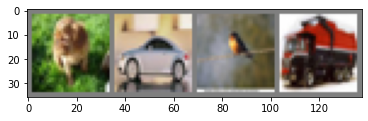

dog   car   bird  truck


In [71]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

In [73]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 3.300
[1,  4000] loss: 2.822
[1,  6000] loss: 2.738
[1,  8000] loss: 2.716
[1, 10000] loss: 2.757
[1, 12000] loss: 2.726
[2,  2000] loss: 2.689
[2,  4000] loss: 2.687
[2,  6000] loss: 2.671
[2,  8000] loss: 2.663
[2, 10000] loss: 2.687
[2, 12000] loss: 2.664
Finished Training


In [75]:
PATH = './cifar_net.pth'
torch.save(cnn.state_dict(), PATH)

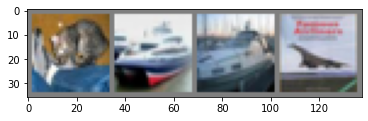

GroundTruth:  cat   ship  ship  plane


In [74]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [76]:
cnn.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [77]:
outputs = cnn(images)

In [78]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  deer  plane plane plane


In [79]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 15 %


In [80]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 78.5 %
Accuracy for class: car   is 12.7 %
Accuracy for class: bird  is 11.4 %
Accuracy for class: cat   is 11.0 %
Accuracy for class: deer  is 9.8 %
Accuracy for class: dog   is 10.1 %
Accuracy for class: frog  is 14.5 %
Accuracy for class: horse is 11.8 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 0.0 %
